In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..','..','..')))
from Code import ScopeBO
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
import matplotlib.pyplot as plt
import matplotlib as mpl
import umap
from sklearn.preprocessing import scale
import random

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

## We generate datasets using different descriptors (DFT, Morfeus, Rdkit, Mordred). Let's first start with the DFT descriptors.

Load the descriptors and filter to the compounds that are in the selected condition datasets.

In [2]:
descriptors = pd.read_csv("Data_For_Individual_Substrates/amide_dft_descr_prods.csv",
                          index_col = 0, header = 0)
descriptors.head(3)

,E,ES_root_dipole,ES_root_electronic_spatial_extent,ES_root_molar_volume,E_scf,E_thermal_correction,E_zpe,G,G_thermal_correction,H,...,N1_ES_root_NPA_valence,N1_Mulliken_charge,N1_NMR_anisotropy,N1_NMR_shift,N1_NPA_Rydberg,N1_NPA_charge,N1_NPA_core,N1_NPA_total,N1_NPA_valence,N1_VBur
can,,,,,,,,,,,,,,,,,,,,,
C#CC(C)(C)NC(=O)C(C)(C)c1ccccc1,-711.561754,2.102901,4174.842003,2383.995411,-711.881745,0.324263,-711.579248,-711.624665,0.261354,-711.560810,...,5.641119,-0.177225,78.125291,132.260424,0.013847,-0.680610,1.999101,7.680610,5.667662,0.719598
C#CC(C)(C)NC(=O)C(c1ccccc1)c1ccccc1,-863.724156,2.375130,6142.366701,1969.705369,-864.070613,0.351615,-863.743612,-863.793593,0.282179,-863.723212,...,5.646138,-0.192679,84.646935,125.449387,0.013480,-0.684047,1.999112,7.684047,5.671463,0.724371
C#CC(C)(C)NC(=O)C1c2ccccc2Oc2ccccc21,-937.659700,2.611506,6183.457968,2753.009551,-937.987955,0.334363,-937.678718,-937.727443,0.266620,-937.658756,...,5.655536,-0.178379,81.777255,127.478451,0.013358,-0.678700,1.999110,7.678700,5.666231,0.706630


In [3]:
# load the full experimental dataset
data = pd.read_csv("./../../amide_proc_experimental_data.csv",index_col=0, header=0)
print(f"The experimental dataset has {len(data)} experiments and "\
      f"{len(data['product_smiles'].unique())} different products.")
data.head(3)

The experimental dataset has 47015 experiments and 632 different products.


,idx,condition_id,sub_1_smiles,sub_2_smiles,product_smiles,Activation_ID,Additive_ID,Base_ID,solvent_id,yield,yield_clf,name0,archive,train_or_test,y_pred,condition_SMILES,text
0,15635,84,Cc1ccc(N)nc1,O=C(O)c1cc2ccccc2s1,Cc1ccc(NC(=O)c2cc3ccccc3s2)nc1,R2,A5,B1,S1,0.431730,1,22003-30-1-PL26-LC1-C84,2208_1,train,0.385567,CC(C)N=C=NC(C)C.C1=CC2=C(N=C1)N(N=N2)O.CN(C)C=O,Cc1ccc(N)nc1.O=C(O)c1cc2ccccc2s1.CC(C)N=C=NC(C...
1,4731,28,NCc1ccc(F)cc1F,O=C(O)c1ccco1,O=C(NCc1ccc(F)cc1F)c1ccco1,R8,A7,B7,S1,0.720284,1,22003-14-1-PL26-LC1-C28,2208_1,train,0.690787,CCN=C=NCCCN(C)C.Cl.C1=CC=C2C(=C1)C(=O)N(C2=O)O...,NCc1ccc(F)cc1F.O=C(O)c1ccco1.CCN=C=NCCCN(C)C.C...
2,22762,12,NCc1ccc(Cl)cc1,O=C(O)c1cccc(-c2ccccc2)c1,O=C(NCc1ccc(Cl)cc1)c1cccc(-c2ccccc2)c1,R19,A1,B7,S1,0.510634,1,22003-33-1-PL24-LC1-C12,2209_3,train,0.423631,[B-](F)(F)(F)F.CN(C)C(=[N+](C)C)ON1C(=O)CCC1=O...,NCc1ccc(Cl)cc1.O=C(O)c1cccc(-c2ccccc2)c1.[B-](...


In [4]:
# variable for the conditons of interest
datasets = {"high": 20, "medium": 24, "low": 87}

In [5]:
# load the shared products of the selected conditions 
shared_prods = pd.read_csv("./../0_Descriptor_Generation/amide_smiles_products_filtered.csv",
                           names=["Products","Combinations"])
print(f"There are {len(shared_prods['Products'].unique())} shared products.")

# limit the descriptors to the ones for the shared products
descriptors = descriptors.loc[descriptors.index.isin(shared_prods["Products"].to_list())]
print(f"After filtering, there are descriptors for {len(descriptors)} products.")

There are 522 shared products.
After filtering, there are descriptors for 522 products.


In [6]:
# filter the experimental dataset to only retain the shared products
shared_data = data.loc[data["product_smiles"].isin(shared_prods["Products"].to_list())]
print(f"The filtered experimental dataset now contains"\
      f" {len(shared_data['product_smiles'].unique())} unique products.")

The filtered experimental dataset now contains 522 unique products.


In [7]:
# some reactions were carried out multiple times - average these values
match_columns = ["condition_id", "sub_1_smiles", "sub_2_smiles", "product_smiles",
                 "Activation_ID", "Additive_ID", "Base_ID", "solvent_id", "condition_SMILES"]
shared_data = shared_data.groupby(match_columns,as_index=False)["yield"].mean()

In [8]:
# create_reaction_space() (function for preprocessing) needs a csv as input - needs to be generated
descriptors.to_csv("preprocessing_dummy.csv", index = True, header = True)
# run the function to preprocess
df_processed = ScopeBO().create_reaction_space(reactants = ["preprocessing_dummy.csv"],
                                               feature_processing = True, suggest_samples=False,
                                               filename = "./Descriptors_For_Substrate_Combinations"\
                                                "/amide_processed_descr_dft_prod.csv")
print(f"There are {len(df_processed.columns)} features in the final datasets.")
df_processed = df_processed.sort_index() # sort to ensure consistent ordering between the different datasets
dfs_dset = {}
# assign the yields
for dset in datasets:
    cond_data = shared_data.loc[shared_data["condition_id"] == datasets[dset]]
    cond_data.set_index("product_smiles",inplace=True)
    dfs_dset[dset] = df_processed.copy()
    dfs_dset[dset]["yield"] = dfs_dset[dset].index.map(cond_data["yield"])
    dfs_dset[dset].to_csv(f"./../amide_dset_dft_prod_{dset}-yielding.csv",index=True,header=True)
    print(f"Generated the '{dset}' dataset.")

Now doing feature preprocessing.
The following features were removed: ['charge', 'E_scf', 'E_zpe', 'G', 'G_thermal_correction', 'H', 'H_thermal_correction', 'number_of_atoms', 'zero_point_correction', 'C1_ES_root_NPA_total', 'C1_ES_root_NPA_valence', 'C1_Mulliken_charge', 'C1_NPA_Rydberg', 'C1_NPA_charge', 'C1_NPA_core', 'C1_NPA_total', 'C1_NPA_valence', 'C2_ES_root_NPA_total', 'C2_ES_root_NPA_valence', 'C2_NPA_core', 'C2_NPA_total', 'C2_NPA_valence', 'O1_ES_root_NPA_charge', 'O1_ES_root_NPA_total', 'O1_ES_root_NPA_valence', 'O1_NPA_total', 'O1_NPA_valence', 'N1_ES_root_NPA_total', 'N1_ES_root_NPA_valence', 'N1_Mulliken_charge', 'N1_NPA_Rydberg', 'N1_NPA_core', 'N1_NPA_total', 'N1_NPA_valence']
The final search space has 52 features.
Generation of reaction space completed!
The search space has been saved in the file './Descriptors_For_Substrate_Combinations/amide_processed_descr_dft_prod.csv.'
There are 52 features in the final datasets.
Generated the 'high' dataset.
Generated the 'med

Let's visualize the data distribution on a UMAP

Distribution of yields:


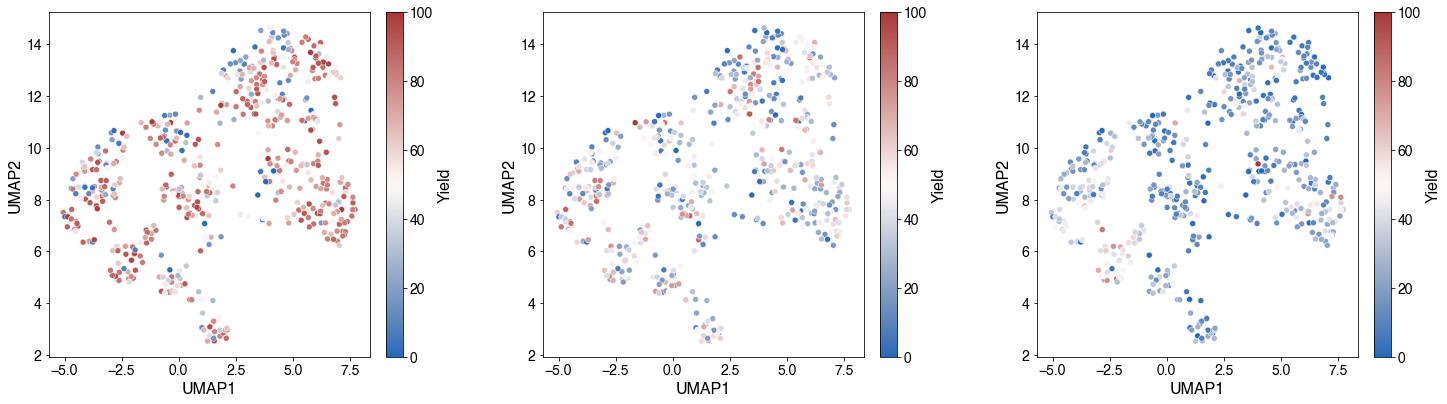

In [9]:
# Visualize the distribution
print("Distribution of yields:")
fig,axes = plt.subplots(1,3,figsize=(20,5.5),gridspec_kw={"wspace":0.1},constrained_layout=True)
for i,dset in enumerate(datasets):
    ax = axes[i]
    yield_list = dfs_dset[dset]["yield"].to_list()
    df_dset = dfs_dset[dset].drop(columns='yield')  # drop the objective values before the umap is generated
    df_dset = pd.DataFrame(scale(df_dset),df_dset.index,df_dset.columns)
    fit = umap.UMAP(n_neighbors=30,min_dist=0.6,n_components=2,metric="euclidean",random_state=42)
    df_umap = pd.DataFrame(fit.fit_transform(df_dset),df_dset.index,["UMAP1","UMAP2"])
    # map the yield data onto the UMAP
    df_umap["yield"] = yield_list
    sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2",hue="yield", 
                    palette="vlag", legend=False, ax = ax)
    df_umap.to_csv(f"./../umap_prods_{dset}.csv")

    # Add a colorbar for the yield
    norm = mpl.colors.Normalize(vmin=0, vmax=100)  # Normalize the colorscale
    sm = plt.cm.ScalarMappable(cmap="vlag", norm=norm)
    sm.set_array([])  # Empty array for ScalarMappable
    cbar = fig.colorbar(sm, ax = ax)
    cbar.set_label('Yield')  # Label for the colorbar
plt.show()

The yield distributions on the UMAPs only show vague correlations between the position on the map and the yield, indicating that the datasets might be challenging to model.

# Do all the above also for the other featurizations

In [10]:
def generate_featurized_and_labelled_datasets(feat):
    print(f"Now working on {feat} featurization.")
    # All the steps involving the experimental HTE dataset can be skipped because the required variables have already been created.

    descriptors = pd.read_csv(f"Data_For_Individual_Substrates/amide_{feat}_descr_prods.csv",
                              index_col = 0, header = 0)
    
    # limit the descriptors to the ones for the shared products
    descriptors = descriptors.loc[descriptors.index.isin(shared_prods["Products"].to_list())]
    print(f"After filtering, there are descriptors for {len(descriptors)} products.")

    # create_reaction_space() (function for preprocessing) needs a csv as input - needs to be generated
    descriptors.to_csv("preprocessing_dummy.csv", index = True, header = True)
    # run the function to preprocess
    df_processed = ScopeBO().create_reaction_space(reactants = ["preprocessing_dummy.csv"],
                                                feature_processing = True, suggest_samples=False,
                                                filename = f"./Descriptors_For_Substrate_Combinations"\
                                                    f"/amide_processed_descr_{feat}_prod.csv")
    print(f"There are {len(df_processed.columns)} features in the final datasets.")
    df_processed = df_processed.sort_index() # sort to ensure consistent ordering between the different datasets
    dfs_dset = {}
    # assign the yields
    for dset in datasets:
        cond_data = shared_data.loc[shared_data["condition_id"] == datasets[dset]]
        cond_data.set_index("product_smiles",inplace=True)
        dfs_dset[dset] = df_processed.copy()
        dfs_dset[dset]["yield"] = dfs_dset[dset].index.map(cond_data["yield"])
        dfs_dset[dset].to_csv(f"./../amide_dset_{feat}_prod_{dset}-yielding.csv",index=True,header=True)
        print(f"Generated the '{dset}' dataset.")
    print(f"Finished dataset generation for {feat} featurization.\n")

    return dfs_dset

In [11]:
for feat in ["mordred","morfeus","rdkit"]:
    _ = generate_featurized_and_labelled_datasets(feat)

Now working on mordred featurization.
After filtering, there are descriptors for 522 products.
Now doing feature preprocessing.
The following features were removed: ['nAcid', 'nBridgehead', 'nB', 'nP', 'nI', 'NsLi', 'NssBe', 'NssssBe', 'NssBH', 'NsssB', 'NssssB', 'NdCH2', 'NddC', 'NsNH3', 'NsNH2', 'NssNH2', 'NdNH', 'NsssNH', 'NdsN', 'NssssN', 'NsOH', 'NsSiH3', 'NssSiH2', 'NsssSiH', 'NssssSi', 'NsPH2', 'NssPH', 'NsssP', 'NdsssP', 'NsssssP', 'NsSH', 'NdS', 'NdssS', 'NsGeH3', 'NssGeH2', 'NsssGeH', 'NssssGe', 'NsAsH2', 'NssAsH', 'NsssAs', 'NsssdAs', 'NsssssAs', 'NsSeH', 'NdSe', 'NssSe', 'NaaSe', 'NdssSe', 'NddssSe', 'NsSnH3', 'NssSnH2', 'NsssSnH', 'NssssSn', 'NsI', 'NsPbH3', 'NssPbH2', 'NsssPbH', 'NssssPb', 'SsLi', 'SssBe', 'SssssBe', 'SssBH', 'SsssB', 'SssssB', 'SdCH2', 'SddC', 'SsNH3', 'SsNH2', 'SssNH2', 'SdNH', 'SsssNH', 'SdsN', 'SssssN', 'SsOH', 'SsSiH3', 'SssSiH2', 'SsssSiH', 'SssssSi', 'SsPH2', 'SssPH', 'SsssP', 'SdsssP', 'SsssssP', 'SsSH', 'SdS', 'SdssS', 'SsGeH3', 'SssGeH2', 'SsssG

In [ ]:
# Clean up unnessary files
current_dir = os.getcwd()
for filename in os.listdir(current_dir):
    if "preprocessing" in filename or filename.startswith("amide_fully_combinatorial"):
        file_path = os.path.join(current_dir, filename)
        os.remove(file_path)
        print(f"Deleted: {filename}")

Deleted: preprocessing_dummy.csv
